In [1]:
import math
from scipy.special import expit
from shap.maskers import Independent
from plots import plot_shap_values_hierarchically_clustered, plot_shap_value_distribution, \
    plot_shap_partial_dependence, plot_shap_values_stacked, plot_decision_boundary
import shap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
shap.initjs()

# Linear vs Stepped Decision Boundary

## Create Models

In [2]:
a = 0.5

f1 = lambda X: np.array([5 if x[0] + x[1] > 0.0 else -5 for x in X])
f2 = lambda X: np.array([5 if math.ceil(x[0]/a - 0.25)*a + math.ceil(x[1]/a - 0.25)*a > 0.0 else -5 for x in X])

c1 = lambda X: expit(f1(X))
c2 = lambda X: expit(f2(X))

In [3]:
feature_names = ['x1', 'x2']
num_samples = 500
x_from = -1
x_to = 1
rng = np.random.RandomState(2)
X = rng.uniform(x_from, x_to, (num_samples, len(feature_names)))

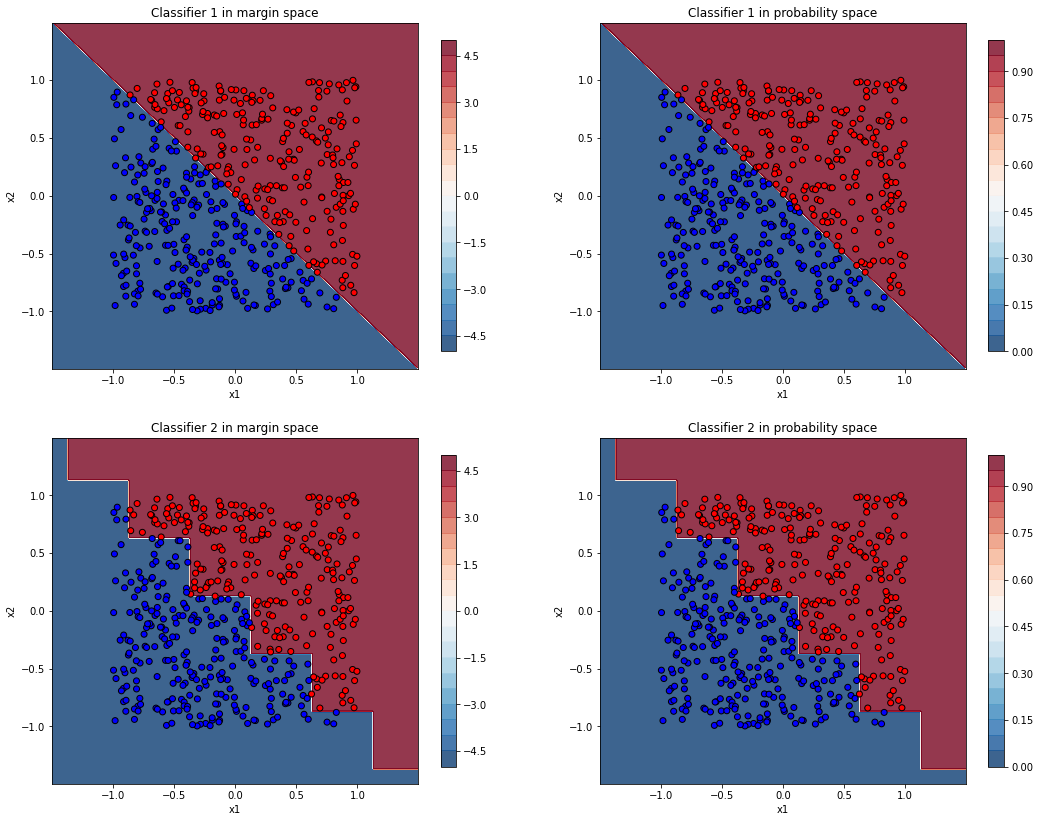

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_decision_boundary(f1, X, 'Classifier 1 in margin space', feature_names, (-5, 5), fig, axs[0,0])
plot_decision_boundary(f2, X, 'Classifier 2 in margin space', feature_names, (-5, 5), fig, axs[1,0])
plot_decision_boundary(c1, X, 'Classifier 1 in probability space', feature_names, (0, 1), fig, axs[0,1])
plot_decision_boundary(c2, X, 'Classifier 2 in probability space', feature_names, (0, 1), fig, axs[1,1])
plt.show()

In [5]:
complement = lambda p: 1 - p
c1_positive_and_c2_negative = lambda p1, p2: p1 * complement(p2)
c1_negative_and_c2_positive = lambda p1, p2: complement(p1) * p2
c1_and_c2_different = lambda p1, p2: c1_positive_and_c2_negative(p1, p2) + c1_negative_and_c2_positive(p1, p2)
odds = lambda p: p / complement(p)
log_odds_ratio_from_proba = lambda p1, p2: np.log(odds(p1) / odds(p2))

c_c1_positive_and_c2_negative = lambda X: c1_positive_and_c2_negative(c1(X), c2(X))
c_c1_negative_and_c2_positive = lambda X: c1_negative_and_c2_positive(c1(X), c2(X))
c_c1_and_c2_different = lambda X: c1_and_c2_different(c1(X), c2(X))
f_log_odds_ratio_from_proba = lambda X: log_odds_ratio_from_proba(c1(X), c2(X))

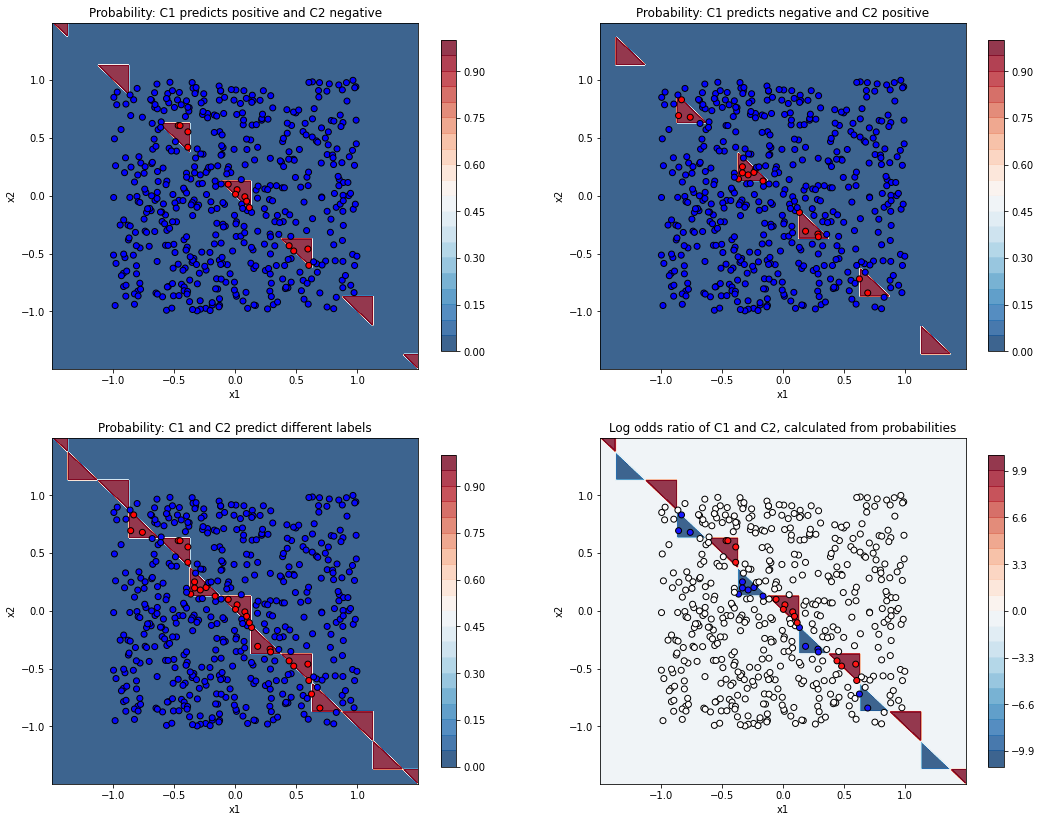

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_decision_boundary(c_c1_positive_and_c2_negative, X, 'Probability: C1 predicts positive and C2 negative', feature_names, (0, 1), fig, axs[0,0])
plot_decision_boundary(c_c1_negative_and_c2_positive, X, 'Probability: C1 predicts negative and C2 positive', feature_names, (0, 1), fig, axs[0,1])
plot_decision_boundary(c_c1_and_c2_different, X, 'Probability: C1 and C2 predict different labels', feature_names, (0, 1), fig, axs[1,0])
plot_decision_boundary(f_log_odds_ratio_from_proba, X, 'Log odds ratio of C1 and C2, calculated from probabilities', feature_names, (-11, 11), fig, axs[1,1])
plt.show()

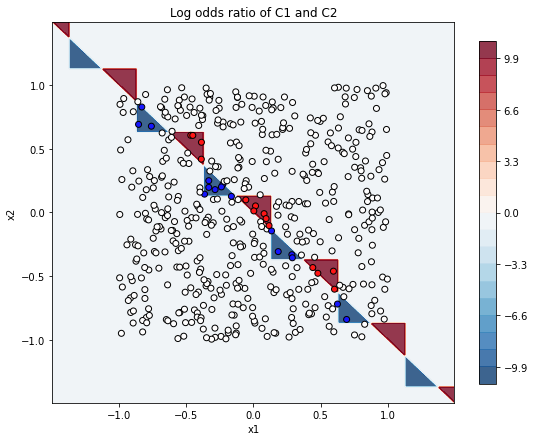

In [7]:
log_odds_ratio = lambda y1, y2: y1 - y2
f_log_odds_ratio = lambda X: log_odds_ratio(f1(X), f2(X))
plot_decision_boundary(f_log_odds_ratio, X, 'Log odds ratio of C1 and C2', feature_names, (-11, 11))

## Generate Explanations

In [8]:
def make_shap_values(model, background_data, feature_names):
    masker = Independent(background_data)
    explainer = shap.Explainer(model, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_f1 = make_shap_values(f1, X, feature_names)
shap_values_f2 = make_shap_values(f2, X, feature_names)
shap_values_c1 = make_shap_values(c1, X, feature_names)
shap_values_c2 = make_shap_values(c2, X, feature_names)

In [9]:
shap_values_c_c1_positive_and_c2_negative = make_shap_values(c_c1_positive_and_c2_negative, X, feature_names)
shap_values_c_c1_negative_and_c2_positive = make_shap_values(c_c1_negative_and_c2_positive, X, feature_names)
shap_values_c_c1_and_c2_different = make_shap_values(c_c1_and_c2_different, X, feature_names)
shap_values_f_log_odds_ratio = make_shap_values(f_log_odds_ratio, X, feature_names)

## Analyze

### SHAP Value Distribution

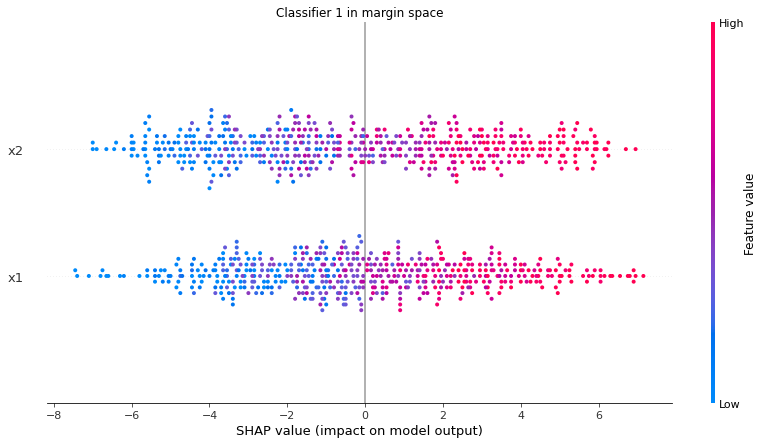

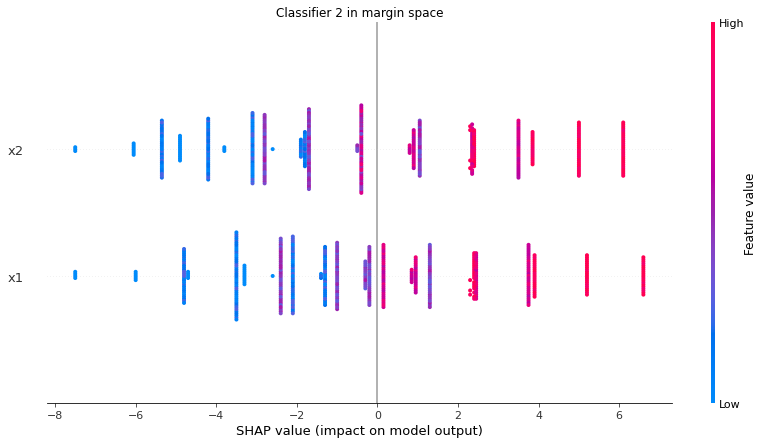

In [10]:
plot_shap_value_distribution(shap_values_f1, 'Classifier 1 in margin space')
plot_shap_value_distribution(shap_values_f2, 'Classifier 2 in margin space')

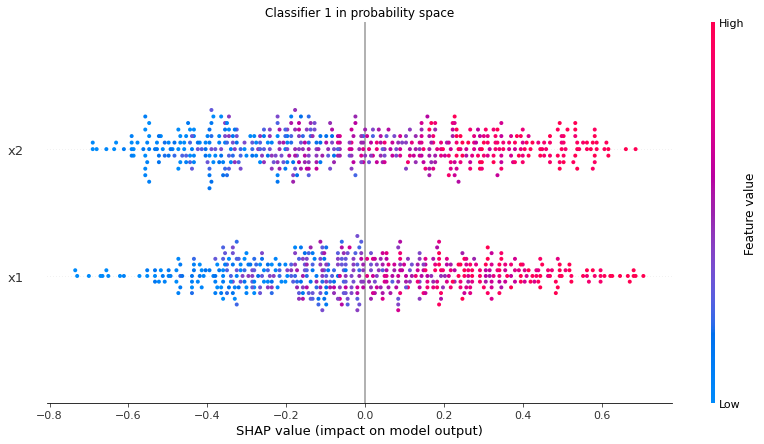

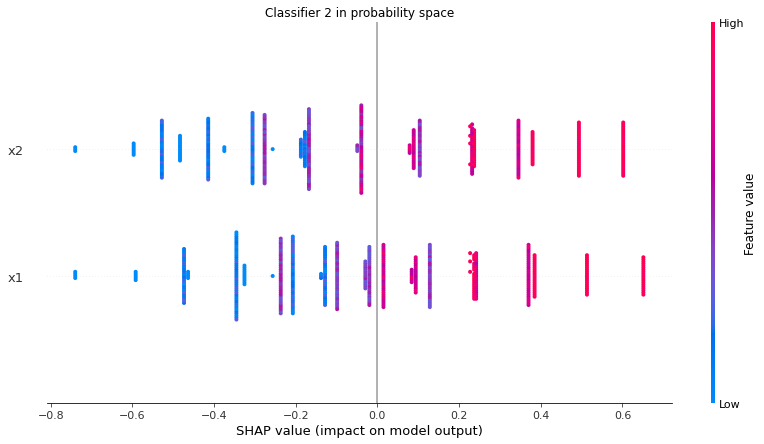

In [11]:
plot_shap_value_distribution(shap_values_c1, 'Classifier 1 in probability space')
plot_shap_value_distribution(shap_values_c2, 'Classifier 2 in probability space')

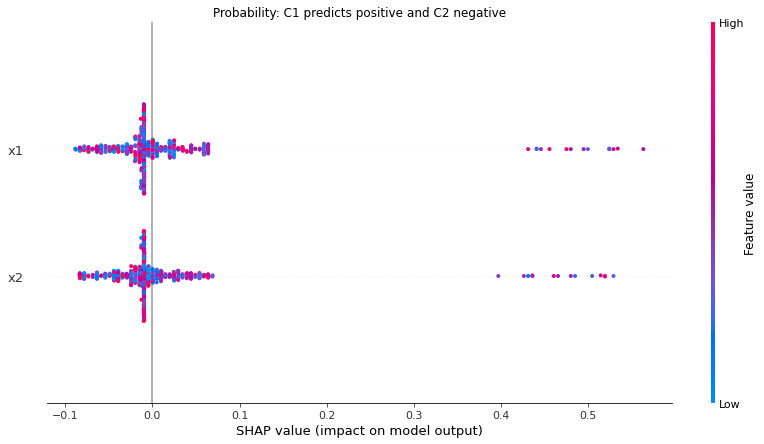

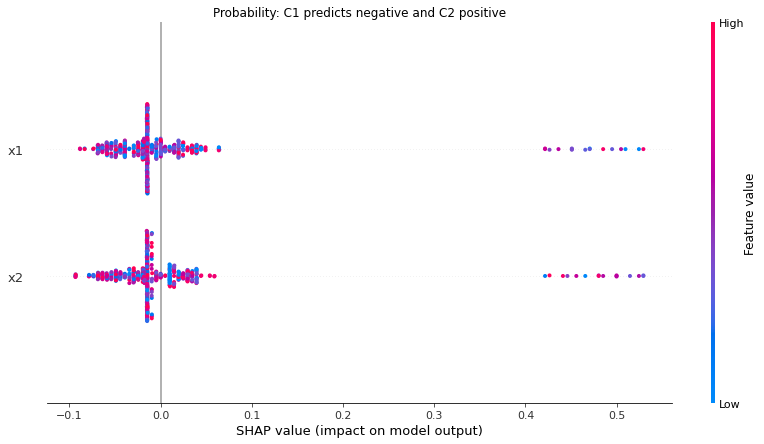

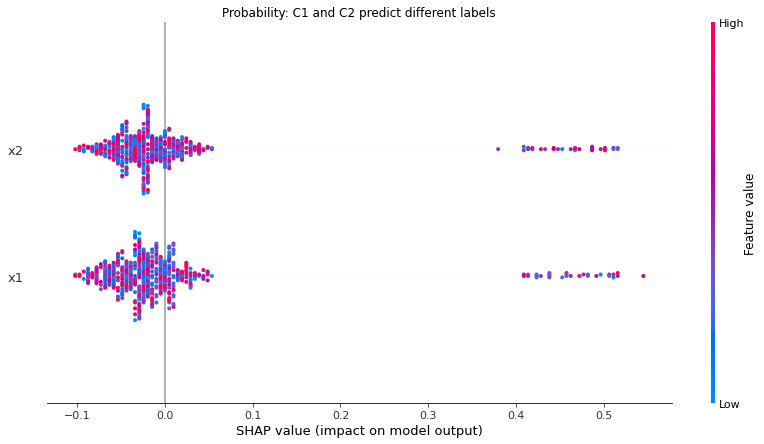

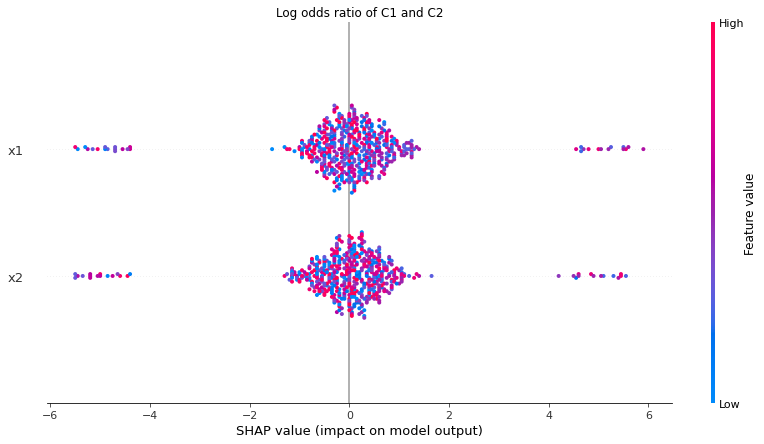

In [12]:
plot_shap_value_distribution(shap_values_c_c1_positive_and_c2_negative, 'Probability: C1 predicts positive and C2 negative')
plot_shap_value_distribution(shap_values_c_c1_negative_and_c2_positive, 'Probability: C1 predicts negative and C2 positive')
plot_shap_value_distribution(shap_values_c_c1_and_c2_different, 'Probability: C1 and C2 predict different labels')
plot_shap_value_distribution(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2')

In [13]:
print(shap_values_f_log_odds_ratio.base_values[0])
print(np.mean(f_log_odds_ratio(X)))

-0.1
-0.04


### Features' Partial Dependence Plots

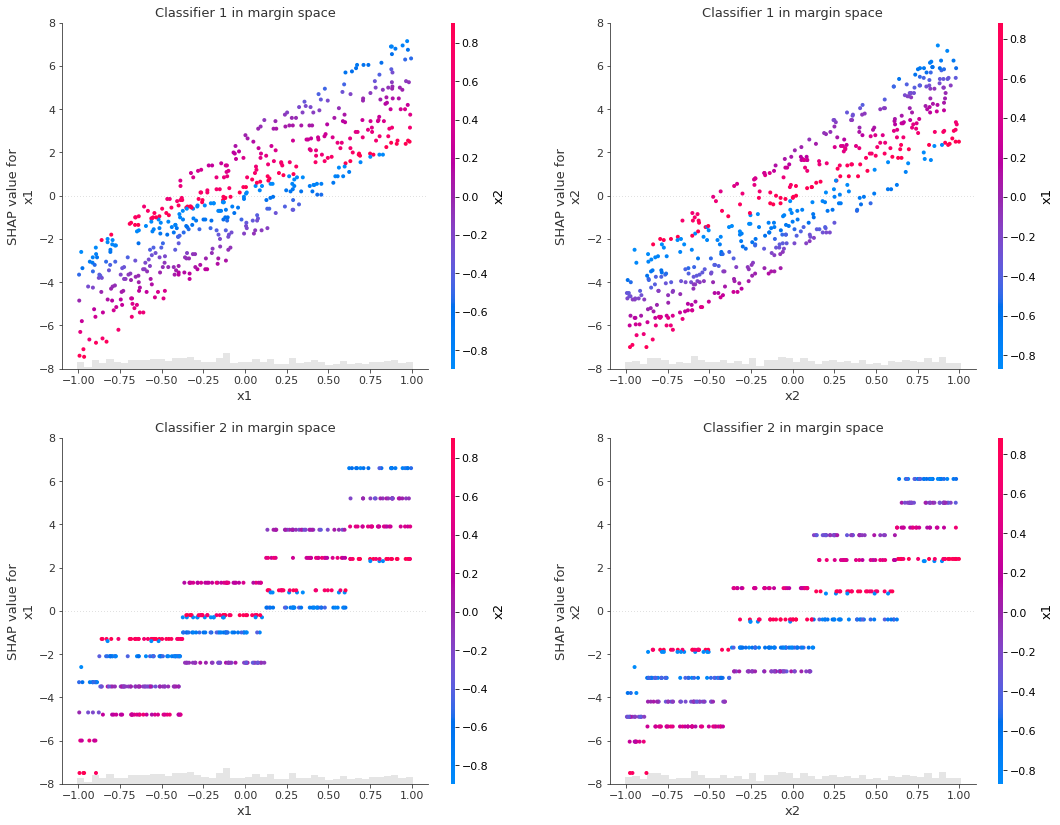

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_shap_partial_dependence(shap_values_f1, feature_names[0], 'Classifier 1 in margin space', (-8, 8), axs[0,0])
plot_shap_partial_dependence(shap_values_f1, feature_names[1], 'Classifier 1 in margin space', (-8, 8), axs[0,1])
plot_shap_partial_dependence(shap_values_f2, feature_names[0], 'Classifier 2 in margin space', (-8, 8), axs[1,0])
plot_shap_partial_dependence(shap_values_f2, feature_names[1], 'Classifier 2 in margin space', (-8, 8), axs[1,1])
plt.show()

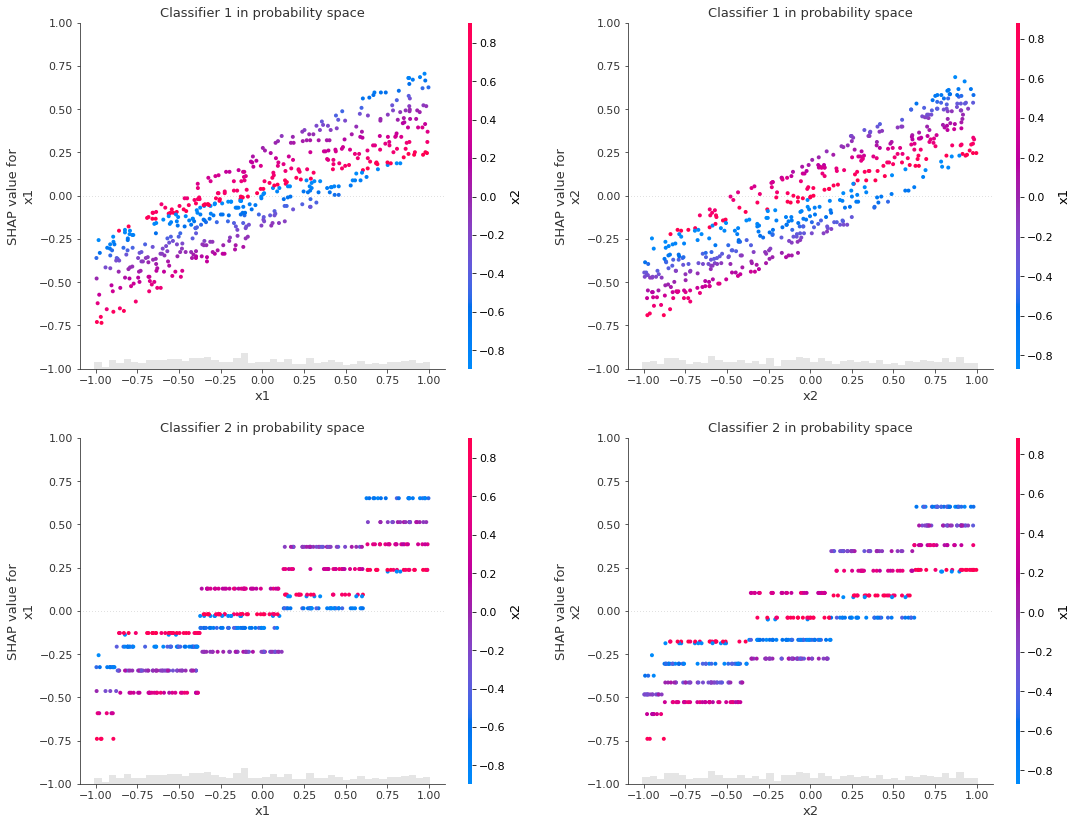

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_shap_partial_dependence(shap_values_c1, feature_names[0], 'Classifier 1 in probability space', (-1, 1), axs[0,0])
plot_shap_partial_dependence(shap_values_c1, feature_names[1], 'Classifier 1 in probability space', (-1, 1), axs[0,1])
plot_shap_partial_dependence(shap_values_c2, feature_names[0], 'Classifier 2 in probability space', (-1, 1), axs[1,0])
plot_shap_partial_dependence(shap_values_c2, feature_names[1], 'Classifier 2 in probability space', (-1, 1), axs[1,1])
plt.show()

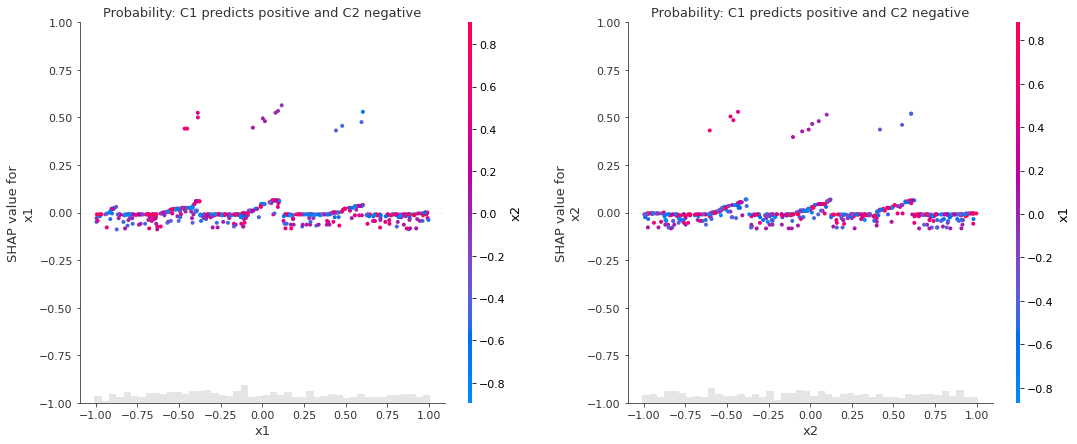

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_c_c1_positive_and_c2_negative, feature_names[0], 'Probability: C1 predicts positive and C2 negative', (-1, 1), axs[0])
plot_shap_partial_dependence(shap_values_c_c1_positive_and_c2_negative, feature_names[1], 'Probability: C1 predicts positive and C2 negative', (-1, 1), axs[1])
plt.show()

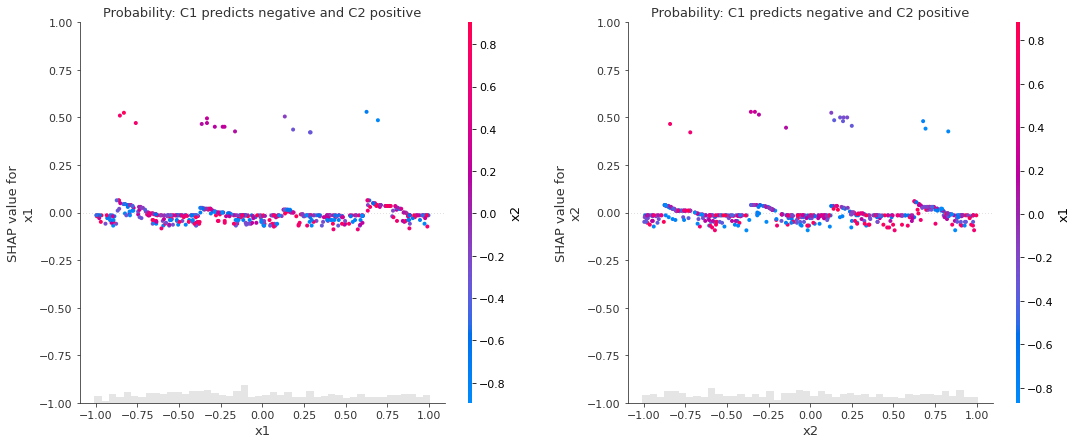

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_c_c1_negative_and_c2_positive, feature_names[0], 'Probability: C1 predicts negative and C2 positive', (-1, 1), axs[0])
plot_shap_partial_dependence(shap_values_c_c1_negative_and_c2_positive, feature_names[1], 'Probability: C1 predicts negative and C2 positive', (-1, 1), axs[1])
plt.show()

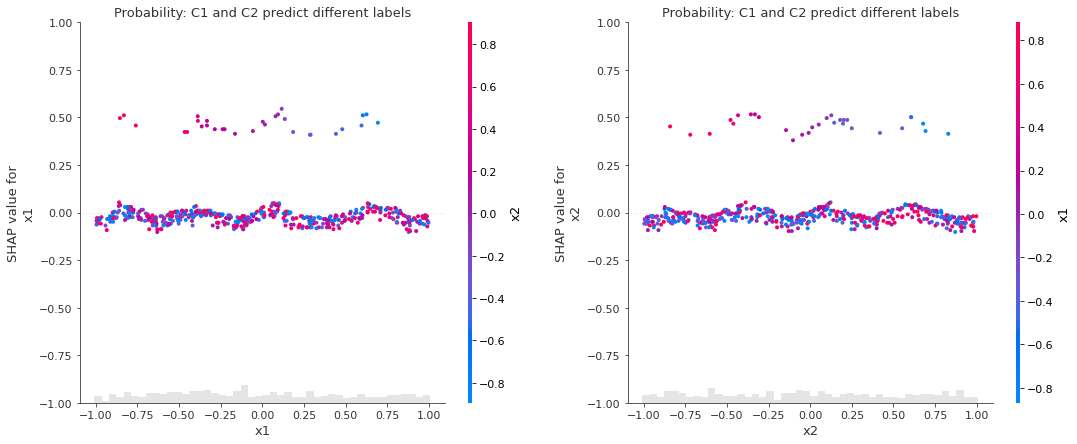

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_c_c1_and_c2_different, feature_names[0], 'Probability: C1 and C2 predict different labels', (-1, 1), axs[0])
plot_shap_partial_dependence(shap_values_c_c1_and_c2_different, feature_names[1], 'Probability: C1 and C2 predict different labels', (-1, 1), axs[1])
plt.show()

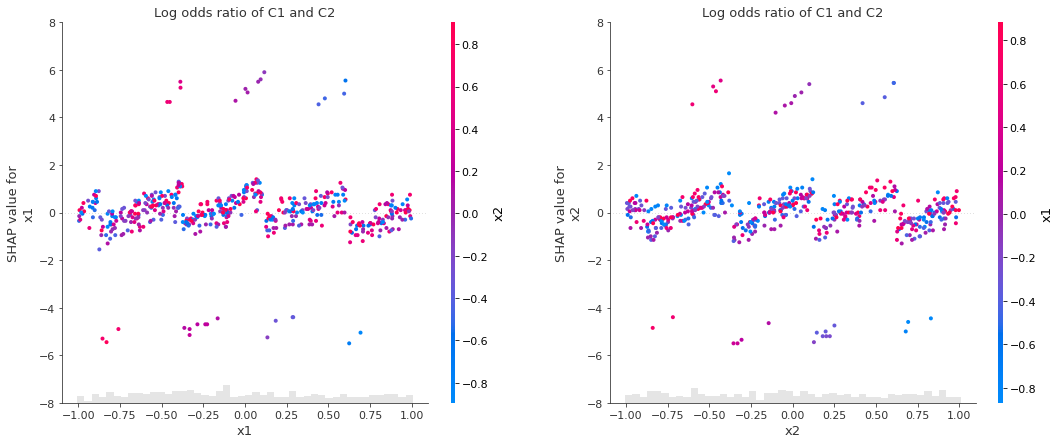

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_f_log_odds_ratio, feature_names[0], 'Log odds ratio of C1 and C2', (-8, 8), axs[0])
plot_shap_partial_dependence(shap_values_f_log_odds_ratio, feature_names[1], 'Log odds ratio of C1 and C2', (-8, 8), axs[1])
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [20]:
ordering = plot_shap_values_stacked(shap_values_f1, 'Classifier 1 in margin space')
plot_shap_values_stacked(shap_values_f2, 'Classifier 2 in margin space', ordering=ordering);

In [21]:
ordering = plot_shap_values_stacked(shap_values_c1, 'Classifier 1 in probability space')
plot_shap_values_stacked(shap_values_c2, 'Classifier 2 in probability space', ordering=ordering);

In [22]:
plot_shap_values_stacked(shap_values_c_c1_positive_and_c2_negative, 'Probability: C1 predicts positive and C2 negative');

In [23]:
plot_shap_values_stacked(shap_values_c_c1_negative_and_c2_positive, 'Probability: C1 predicts negative and C2 positive');

In [24]:
plot_shap_values_stacked(shap_values_c_c1_and_c2_different, 'Probability: C1 and C2 predict different labels');

In [25]:
plot_shap_values_stacked(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2');

### Hierarchically Clustered SHAP Values

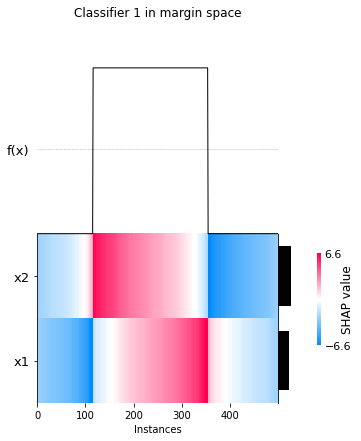

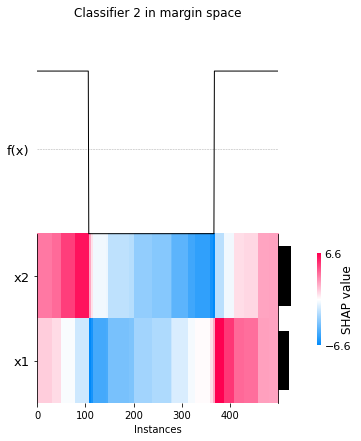

In [26]:
plot_shap_values_hierarchically_clustered(shap_values_f1, 'Classifier 1 in margin space')
plot_shap_values_hierarchically_clustered(shap_values_f2, 'Classifier 2 in margin space')

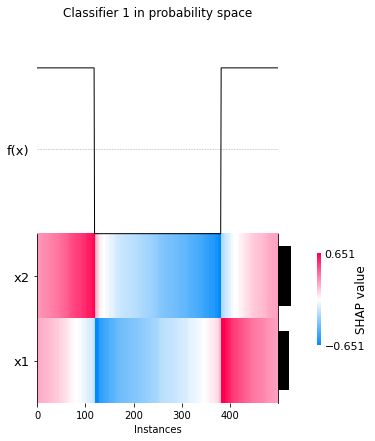

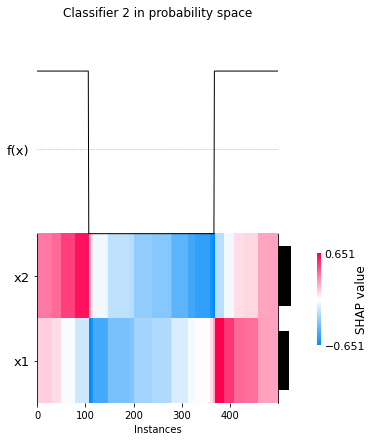

In [27]:
plot_shap_values_hierarchically_clustered(shap_values_c1, 'Classifier 1 in probability space')
plot_shap_values_hierarchically_clustered(shap_values_c2, 'Classifier 2 in probability space')

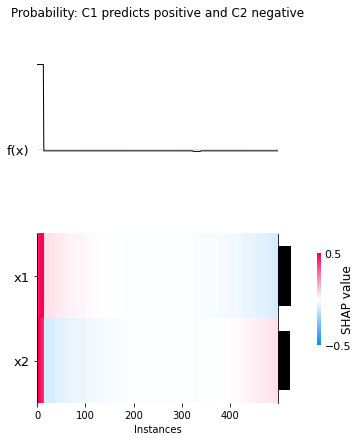

In [28]:
plot_shap_values_hierarchically_clustered(shap_values_c_c1_positive_and_c2_negative, 'Probability: C1 predicts positive and C2 negative')

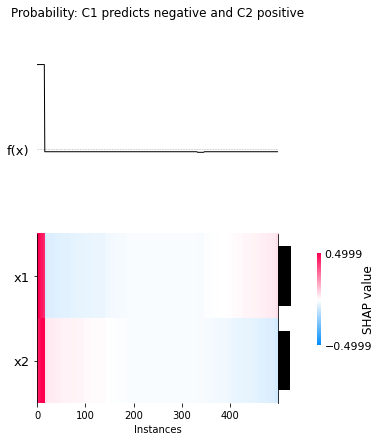

In [29]:
plot_shap_values_hierarchically_clustered(shap_values_c_c1_negative_and_c2_positive, 'Probability: C1 predicts negative and C2 positive')

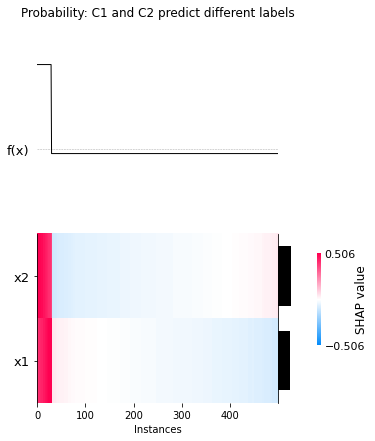

In [30]:
plot_shap_values_hierarchically_clustered(shap_values_c_c1_and_c2_different, 'Probability: C1 and C2 predict different labels')

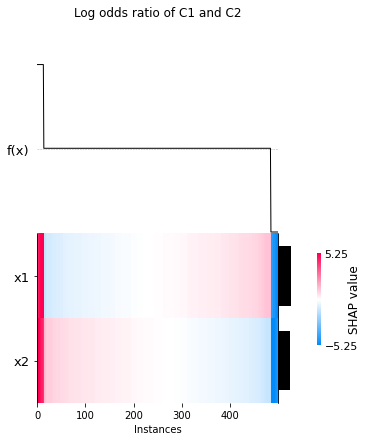

In [31]:
plot_shap_values_hierarchically_clustered(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2')